# Vehicle Routing Problem
The vehicle routing problem (VRP) is a combinatorial optimization and integer 
programming problem seeking to service a number of customers with a fleet of vehicles. 
VRP is an important problem in the fields of transportation, distribution and logistics. Often 
the context is that of delivering goods located at a central depot to customers who have 
placed orders for such goods. Implicit is the goal of minimizing the cost of distributing the 
goods. Many methods have been developed for searching for good solutions to the 
problem, but finding global minimum for the cost function is computationally complex.

Design and develop a genotype model for representing VRP, and also develop an 
Evolutionary Algorithm that can evolve candidate solutions and find the solution.

We are considering the cost function as the distance covered to travel through all the cities exactly once.
We are reducing the the VRP to travelling salesman problem by the assumption that
* If we can reduce the distance travelled to cover the longest route, then we can then we can complete the each route with mininal time and there by accomplish delivery of larger number of orders by allocating multiple routes to vehicle which completes the delivery fast and there by we can reduce the cost and maximise the profit.
## Travelling salesman Problem

Constraints
* Each city needs to be visited exactly one time
* We must return to the starting city, so our total distance needs to be calculated accordingly

opimisation problem
* Our objective is to minimize the distance travelled by saleseman(here vehicle) to travell through all the cities.

# Design of Experiments
GA

* Representation	--------               Permutation of Integer tuples which represents the city


* Fitness          --------   	           Inverse of the route distance


* Recombination	     --------           ordered crossover, elitism size 20	


* Mutation	           --------          Swap


* Mutation Probability	 --------        0.01


* Parent Selection	      --------       Best 2 


* Survival Selection	      --------       rank, roulette wheel, elitislm 20


* Population size	            --------     100


* Number of Offspring	        --------     2


* Initialization 	          --------       Random


* Termination condition	     --------    500 generations

# Program Development

In [18]:
import numpy as np
import  random
import operator
import  pandas as pd
import matplotlib.pyplot as plt

In [19]:

class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2)) #Euclidian distance
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

In [20]:
# Fitness function

class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance()) # we are taking the inverse so that to perform minimisation of distance. Larger fitness permitted
        return self.fitness

In [21]:
# Initial population
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population


In [22]:
#rank base selection

def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum() # Roulette wheel selection
    #print(df)
    for i in range(0, eliteSize):   #Elitism to make sure that the fittest individuals are permitted to next gen properly
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        #pick
        #print(df.iat[i,3])
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

In [23]:
# Mating pool # adding the selected candidates from previous step
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

In [24]:
#Crossover #ordered crossover
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child
def breedPopulation(matingpool, eliteSize):  # Elitism - to make sure that the fittest individuals are permitted to next gen properly
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

In [25]:
#Mutation #swap mutation
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

In [26]:
#survivor selection # putting altogather the steps we have done before
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    #print(len(selectionResults))
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    #print(len(children))
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

In [27]:
#GA
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print(pop)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
  
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

# Output

In [39]:
# run
cityList = []

for i in range(0,25): # number of cities can be varied here.
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

[[(117,96), (157,143), (163,33), (95,160), (8,34), (107,77), (0,27), (142,180), (50,88), (124,84)], [(107,77), (117,96), (50,88), (142,180), (8,34), (124,84), (95,160), (163,33), (157,143), (0,27)], [(95,160), (117,96), (50,88), (142,180), (124,84), (157,143), (0,27), (163,33), (107,77), (8,34)], [(124,84), (117,96), (0,27), (50,88), (107,77), (142,180), (95,160), (8,34), (163,33), (157,143)], [(163,33), (142,180), (8,34), (124,84), (0,27), (50,88), (107,77), (95,160), (157,143), (117,96)], [(157,143), (0,27), (107,77), (142,180), (124,84), (95,160), (163,33), (117,96), (50,88), (8,34)], [(107,77), (157,143), (124,84), (163,33), (0,27), (95,160), (142,180), (8,34), (117,96), (50,88)], [(142,180), (0,27), (117,96), (124,84), (107,77), (8,34), (95,160), (163,33), (50,88), (157,143)], [(107,77), (163,33), (0,27), (117,96), (157,143), (142,180), (50,88), (8,34), (124,84), (95,160)], [(163,33), (142,180), (117,96), (107,77), (0,27), (95,160), (8,34), (50,88), (124,84), (157,143)], [(107,77)

Final distance: 582.7853599672717


[(8,34),
 (0,27),
 (107,77),
 (117,96),
 (124,84),
 (163,33),
 (157,143),
 (142,180),
 (95,160),
 (50,88)]

In [29]:
# visualization
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()


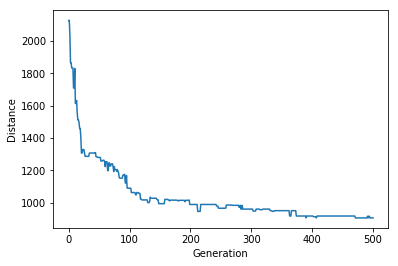

In [30]:
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

# OUT2

In [31]:
geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

[[(173,11), (63,181), (48,63), (106,126), (85,130), (173,10), (4,147), (126,166), (174,53), (129,23), (142,189), (79,7), (9,30), (154,63), (38,103), (120,138), (23,2), (110,67), (164,117), (116,153), (109,146), (27,84), (75,83), (16,158), (116,43)], [(126,166), (173,11), (4,147), (173,10), (79,7), (174,53), (164,117), (110,67), (154,63), (23,2), (38,103), (129,23), (27,84), (109,146), (142,189), (48,63), (9,30), (106,126), (116,153), (120,138), (16,158), (116,43), (85,130), (75,83), (63,181)], [(110,67), (120,138), (16,158), (129,23), (142,189), (116,43), (75,83), (38,103), (164,117), (173,10), (126,166), (23,2), (48,63), (4,147), (63,181), (27,84), (85,130), (154,63), (106,126), (174,53), (109,146), (9,30), (79,7), (116,153), (173,11)], [(106,126), (116,43), (154,63), (48,63), (85,130), (27,84), (174,53), (116,153), (142,189), (173,11), (120,138), (126,166), (23,2), (110,67), (75,83), (173,10), (109,146), (38,103), (79,7), (9,30), (63,181), (164,117), (16,158), (129,23), (4,147)], [(1

Final distance: 950.1951419822202


[(174,53),
 (173,11),
 (173,10),
 (129,23),
 (116,43),
 (79,7),
 (23,2),
 (9,30),
 (48,63),
 (85,130),
 (106,126),
 (120,138),
 (109,146),
 (116,153),
 (126,166),
 (142,189),
 (63,181),
 (16,158),
 (4,147),
 (38,103),
 (27,84),
 (75,83),
 (110,67),
 (164,117),
 (154,63)]

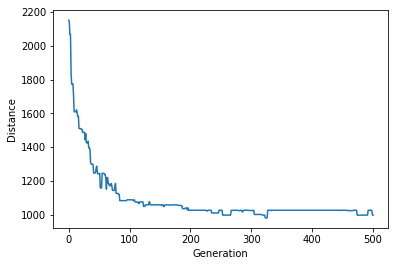

In [32]:
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

# OUT3

In [35]:
geneticAlgorithm(population=cityList, popSize=100, eliteSize=15, mutationRate=0.01, generations=500)

[[(79,7), (164,117), (174,53), (116,43), (110,67), (142,189), (85,130), (27,84), (173,10), (4,147), (109,146), (154,63), (120,138), (48,63), (63,181), (75,83), (126,166), (116,153), (106,126), (129,23), (23,2), (38,103), (16,158), (9,30), (173,11)], [(85,130), (154,63), (75,83), (16,158), (9,30), (173,10), (142,189), (116,153), (164,117), (120,138), (27,84), (116,43), (106,126), (110,67), (109,146), (63,181), (126,166), (23,2), (79,7), (174,53), (129,23), (4,147), (38,103), (173,11), (48,63)], [(129,23), (174,53), (116,153), (164,117), (154,63), (142,189), (85,130), (9,30), (16,158), (63,181), (79,7), (109,146), (48,63), (23,2), (110,67), (27,84), (75,83), (126,166), (173,10), (4,147), (106,126), (120,138), (38,103), (173,11), (116,43)], [(23,2), (126,166), (48,63), (16,158), (173,10), (109,146), (116,153), (174,53), (142,189), (75,83), (27,84), (129,23), (120,138), (106,126), (110,67), (173,11), (4,147), (85,130), (154,63), (164,117), (116,43), (38,103), (79,7), (9,30), (63,181)], [(1

Final distance: 948.1795449975788


[(27,84),
 (38,103),
 (4,147),
 (16,158),
 (63,181),
 (109,146),
 (116,153),
 (126,166),
 (142,189),
 (120,138),
 (85,130),
 (106,126),
 (164,117),
 (154,63),
 (174,53),
 (173,11),
 (173,10),
 (129,23),
 (116,43),
 (110,67),
 (75,83),
 (48,63),
 (9,30),
 (23,2),
 (79,7)]

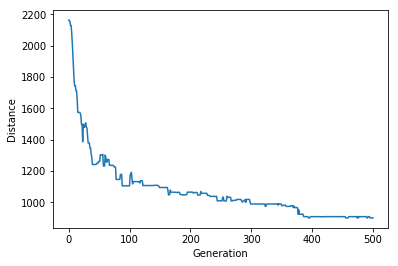

In [38]:
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

In [ ]:




+